Read in all data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from utils import stratified_sample, annotate, even_train_split
import glob  # Importing the glob module to find all the files matching a pattern

# Pattern to match the data files
file_pattern = "data_files/user_*/metric_df.csv"

# Initialize a dictionary to store Dataframes for each dataset
all_datasets = {}

# Loop through each file that matches the file pattern
for filepath in glob.glob(file_pattern):
    # print(filepath)
    # print(filepath.split('/'))
    # user_name = filepath.split('/')[1]
    user_name = filepath.split('\\')[1]
    print(f"Processing {filepath} dataset...")

    # Read in data file as a pandas dataframe
    data = pd.read_csv(filepath, index_col=0)

    # add weighted performance metric
    w = 1
    data["weighted_performance"] = 10*data['throughput'] - w*(data['avg_osd'] + data['avg_target_error'])

    all_datasets[user_name] = data

# Combine datasets for Lizzie
lizzie1 = all_datasets["user_lizzie1"]
lizzie2 = all_datasets["user_lizzie2"]
combined_df = pd.concat([lizzie1, lizzie2])
all_datasets["user_lizzie"] = combined_df.groupby(['latency', 'scale']).mean().reset_index()

Modeling

In [ ]:
from models import PolyRegression, GPRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, RationalQuadratic
import utils


all_results = {}
output_metrics = ["throughput", "avg_target_error", "avg_osd", "avg_movement_speed", "weighted_performance"]
for output_metric in output_metrics:
	print(output_metric)
	user_results = {}
	for user, data in list(all_datasets.items()): # [("user_lizzie", all_datasets["user_lizzie"])]:  
		print(user)

		# Prepare data 
		X = data[['latency', 'scale']]
		Y = data[output_metric]

		# Initialize evaluation metrics
		optimal_match_rate = []
		optimal_scale_error = []
		mse_scores = []
		full_mse_scores = []
		n_train_mse = []
		n_train_full_mse = []
		n_train_p = []

		n = len(data)
		n_train_values = range(2, n-1)
		for n_train in n_train_values:

			n_train_p.append(n_train / n)
			# Split into training/test sets
			# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=n_train/n)
			train_set, test_set = even_train_split(data, n_train)
			X_train, X_test = train_set[['latency', 'scale']], test_set[['latency', 'scale']]
			Y_train, Y_test = train_set[output_metric], test_set[output_metric]
			
			# Create dense test input
			latency_range = np.array(data['latency'].unique())# np.arange(0.0, 0.76, 0.01)
			scale_range = np.arange(0.0, 1.225, 0.025)
			latency_grid, scale_grid = np.meshgrid(latency_range, scale_range)
			X_dense = np.c_[latency_grid.ravel(), scale_grid.ravel()]
			X_dense = np.round(X_dense, 3)

			## Choose model to apply, returning predictions over original dataset and dense inputs
					
			# # Polynomial Regression
			# degree = 2
			# Y_pred = PolyRegression(X_train.values, Y_train.values, X.values, degree)
			# Y_pred_dense = PolyRegression(X_train.values, Y_train.values, X_dense, degree)

			# Gaussian Process Regression
			# kernel = ConstantKernel() * RBF() # Default RBF
			kernel = ConstantKernel() * RationalQuadratic() # Default Rational Quadratic
			Y_pred, Y_pred_std = GPRegression(X_train.values, Y_train.values, X.values, kernel)
			Y_pred_dense, Y_pred_std = GPRegression(X_train.values, Y_train.values, X_dense, kernel)

			## Evaluate metrics
			dense_df = pd.DataFrame({
					'latency': X_dense[:, 0].flatten(),
					'scale': X_dense[:, 1].flatten(),
					'Y_pred_dense': Y_pred_dense.flatten()
				})
			data["Y_pred"] = Y_pred

			# Mean Square Error on whole dataset
			full_mse = mean_squared_error(Y, Y_pred)
			if True: #full_mse < 5000:
				n_train_full_mse.append(n_train)
				full_mse_scores.append(full_mse)

			# Mean Square Error on test set
			Y_test_pred = data.loc[Y_test.index]["Y_pred"]
			mse = mean_squared_error(Y_test, Y_test_pred)
			if True: #mse < 5000:
				n_train_mse.append(n_train)
				mse_scores.append(mse)
			
			if output_metric in ["throughput", "avg_movement_speed", "weighted_performance"]: # optimal scale at maximum
				optimal_scale_dense = dense_df.loc[dense_df.groupby('latency')['Y_pred_dense'].idxmax()][['latency', 'scale']]
				optimal_scale_ref = data.loc[data.groupby('latency')[output_metric].idxmax()][['latency', 'scale']]
				optimal_scale_pred = data.loc[data.groupby('latency')['Y_pred'].idxmax()][['latency', 'scale']]
			else: # optimal scale at minimum
				optimal_scale_dense = dense_df.loc[dense_df.groupby('latency')['Y_pred_dense'].idxmin()][['latency', 'scale']]
				optimal_scale_ref = data.loc[data.groupby('latency')[output_metric].idxmin()][['latency', 'scale']]
				optimal_scale_pred = data.loc[data.groupby('latency')['Y_pred'].idxmin()][['latency', 'scale']]

			# Merge the results on 'latency'
			merged_ref_pred = pd.merge(optimal_scale_ref, optimal_scale_pred, 
								on='latency', suffixes=('_ref', '_pred'))
			
			merged_ref_dense = pd.merge(optimal_scale_ref, optimal_scale_dense, 
								on='latency', suffixes=('_ref', '_dense'))
			

			# Count the number of matches
			matches = (merged_ref_pred['scale_ref'] == merged_ref_pred['scale_pred']).sum()
			scale_error = np.abs(merged_ref_dense['scale_ref'] - merged_ref_dense['scale_dense']).mean()

			optimal_match_rate.append(matches / len(optimal_scale_ref))
			optimal_scale_error.append(scale_error)

			# Visualize model prediction
			# utils.model_heatmaps(data, dense_df, X_train, user, output_metric)

		# Store results from this dataset
		user_results[user] = {
			'n_train_mse': list(n_train_mse),
			'n_train_full_mse': list(n_train_full_mse),
			'full_mse_scores': full_mse_scores,
			'mse_scores': mse_scores,
			'n_train_all': n_train_values,
			'match_rate': optimal_match_rate,
			'scale_error': optimal_scale_error,
			'n_train_p': n_train_p
		}

	all_results[output_metric] = user_results



Visualize

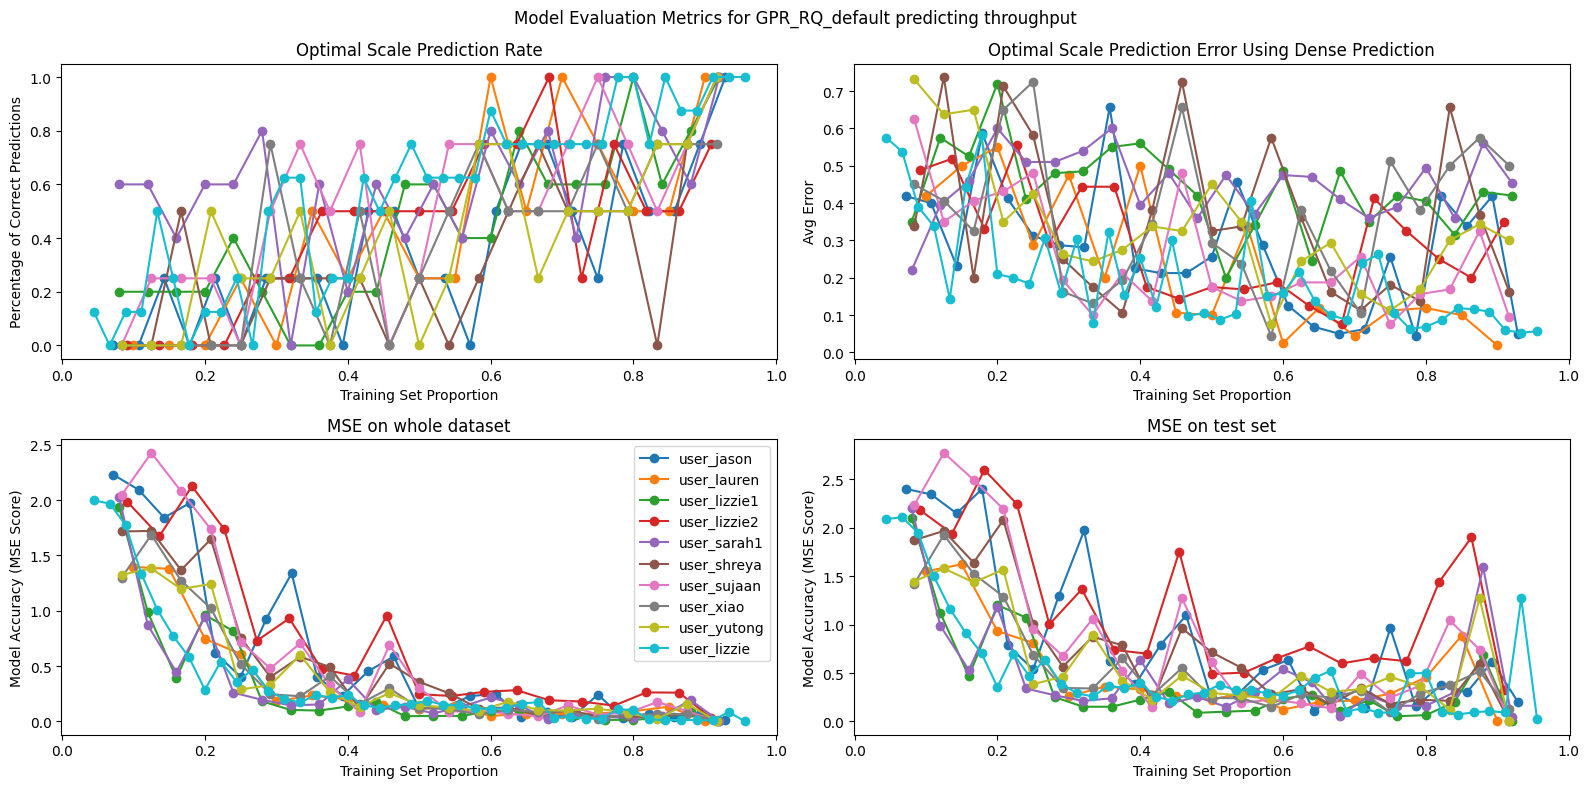

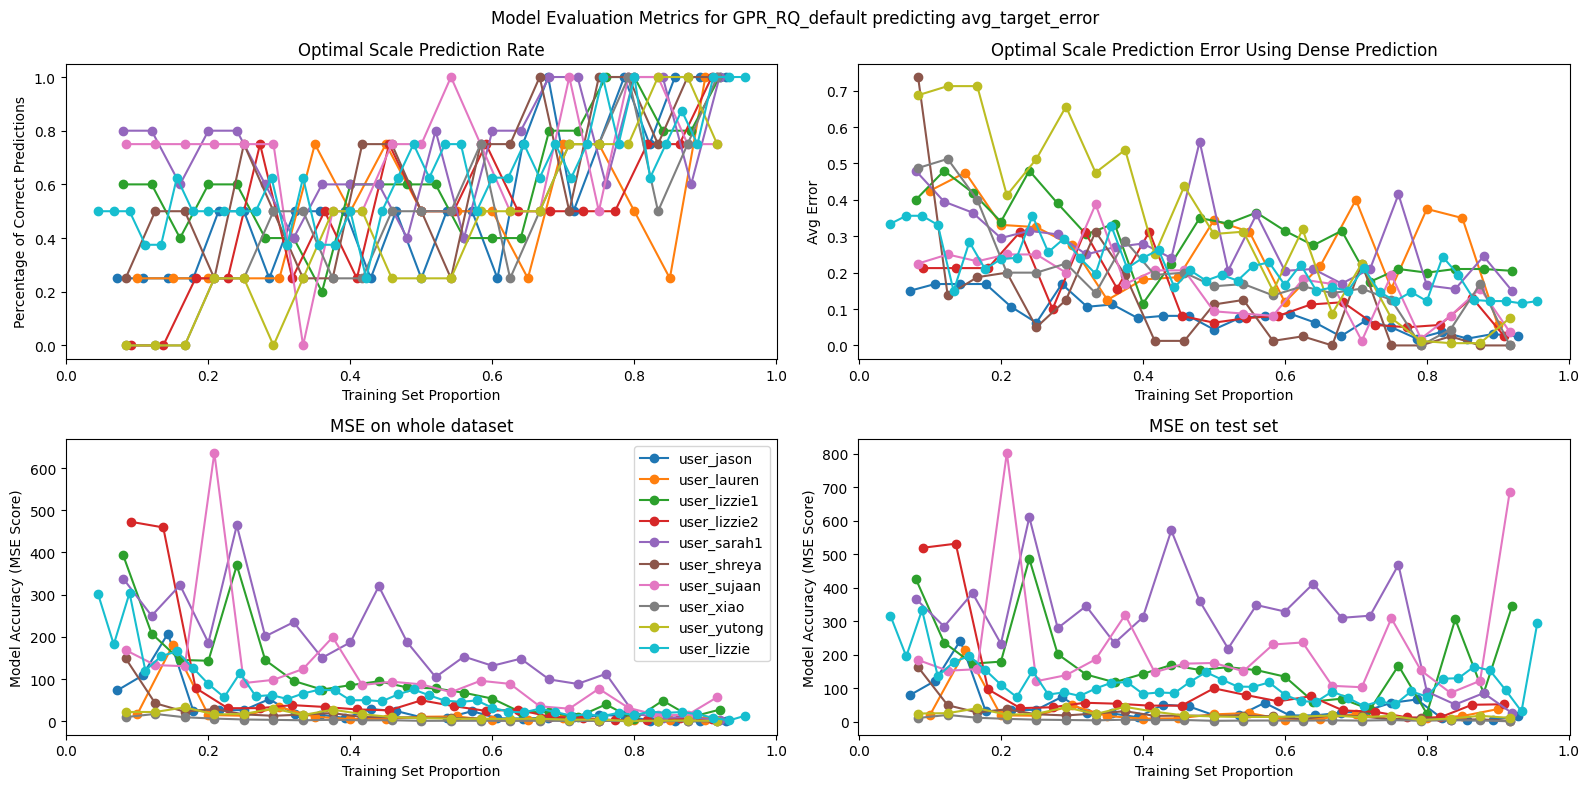

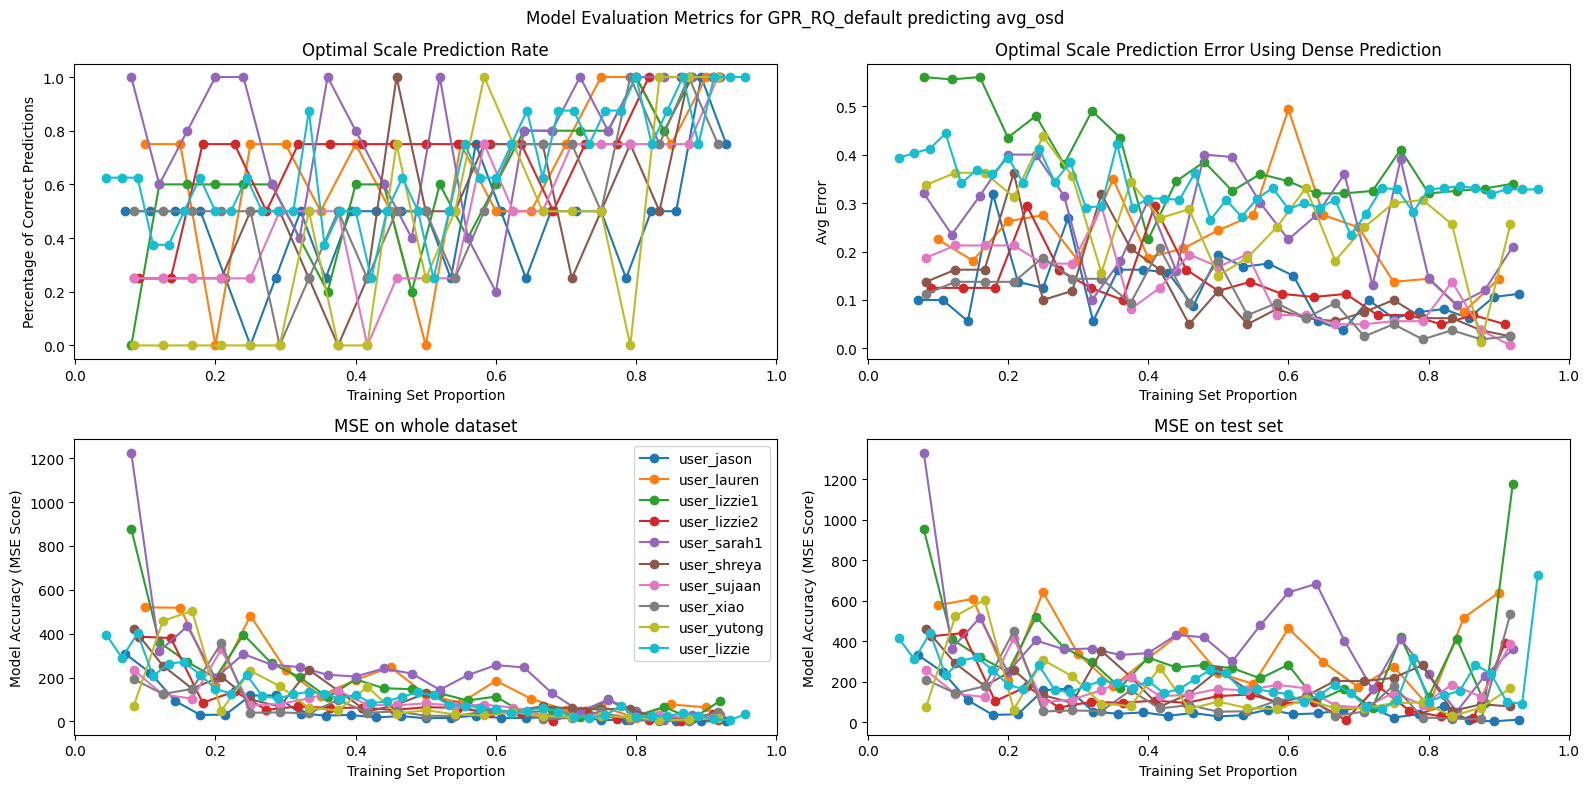

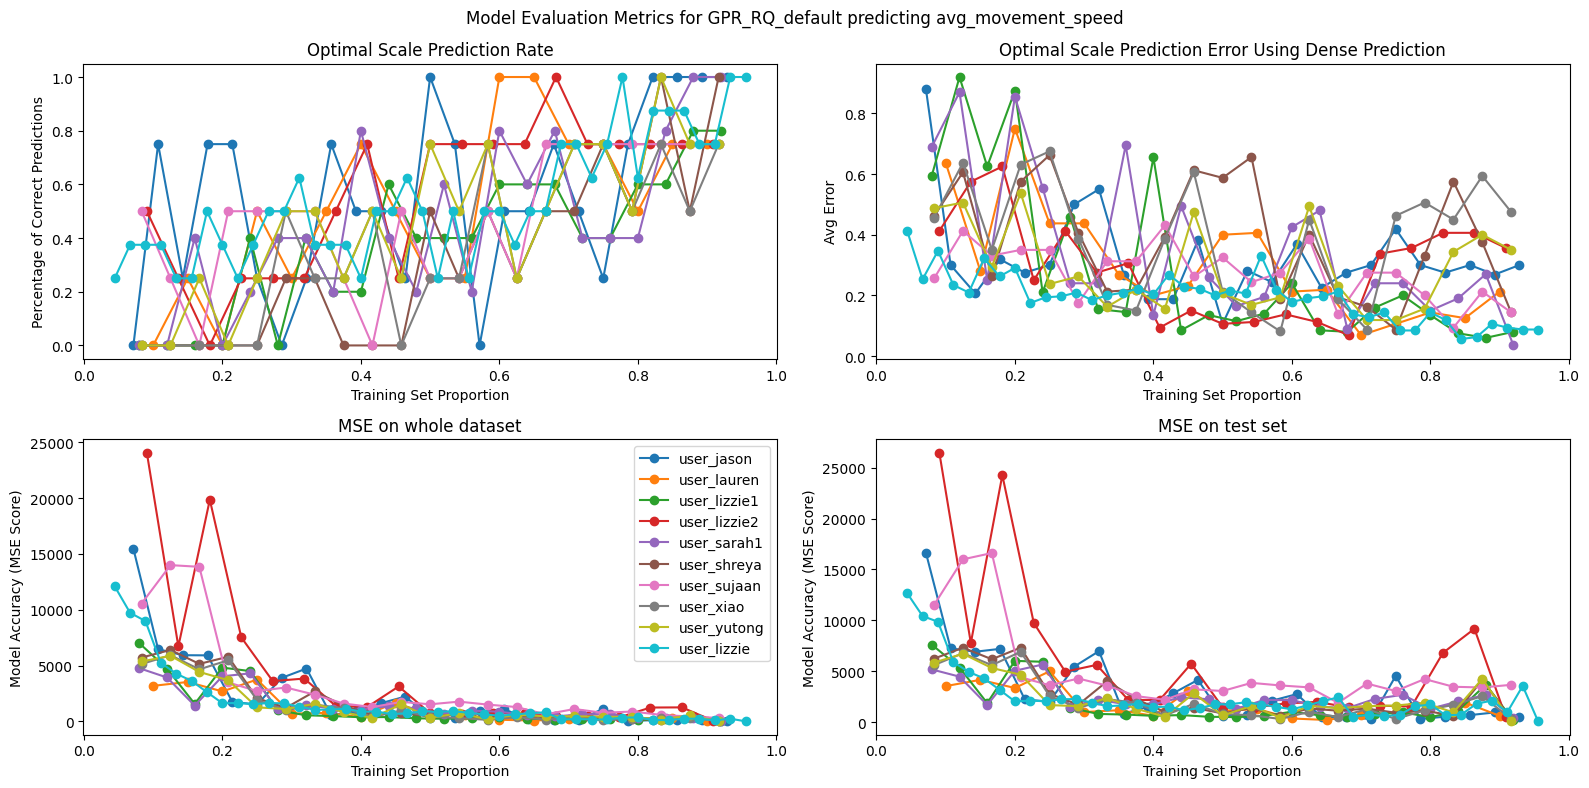

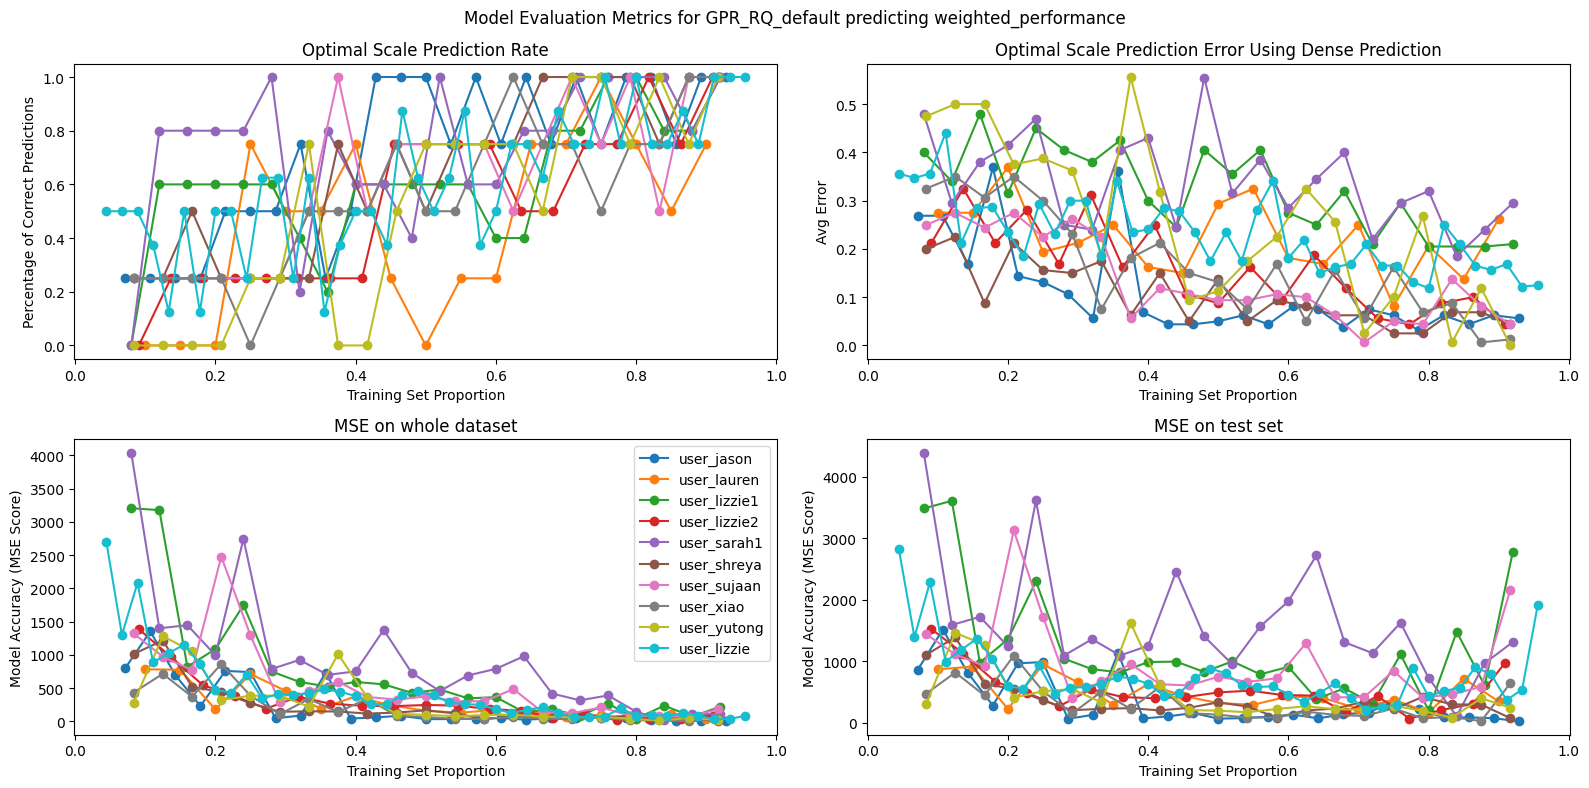

In [22]:
# # Plotting the results for all datasets

model_type = "GPR_RQ_default"
for output_metric, user_results in all_results.items():

	fig, axes = plt.subplots(2, 2, figsize=(16, 8))
	fig.suptitle(f"Model Evaluation Metrics for {model_type} predicting {output_metric}")
	for user, results in user_results.items():
		axes[0, 0].plot(results['n_train_p'], results['match_rate'], marker='o', label=user)
		axes[0, 1].plot(results['n_train_p'], results['scale_error'], marker='o', label=user)
		axes[1, 0].plot(results['n_train_p'], results['full_mse_scores'], marker='o', label=user)
		axes[1, 1].plot(results['n_train_p'], results['mse_scores'], marker='o', label=user)

	axes[0, 0].set_title("Optimal Scale Prediction Rate")
	axes[0, 0].set_xlabel("Training Set Proportion")
	axes[0, 0].set_ylabel("Percentage of Correct Predictions")

	axes[0, 1].set_title("Optimal Scale Prediction Error Using Dense Prediction")
	axes[0, 1].set_xlabel("Training Set Proportion")
	axes[0, 1].set_ylabel("Avg Error")


	axes[1, 0].set_title('MSE on whole dataset')
	axes[1, 0].set_xlabel('Training Set Proportion')
	axes[1, 0].set_ylabel('Model Accuracy (MSE Score)')

	axes[1, 1].set_title('MSE on test set')
	axes[1, 1].set_xlabel('Training Set Proportion')
	axes[1, 1].set_ylabel('Model Accuracy (MSE Score)')
	axes[1, 0].legend()

	plt.tight_layout()
	plt.savefig(f"figures/model_results/{output_metric}/{model_type}_model_eval_metrics_{output_metric}.png", facecolor='w')
	plt.show()


In [ ]:
from utils import annotate_extrema

metric_df = all_datasets["user_lizzie"]
# Create a 2x5 subplot for the heatmaps
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# Define a function to highlight the maximum value in each row
def highlight_max(data):
    max_index = np.argmax(data, axis=1)
    for i, max_col in enumerate(max_index):
        data[i, max_col] = data[i, max_col]
    return data

# Plot the heatmap for throughput
heatmap_throughput = metric_df.pivot(
    index='latency', columns='scale', values='throughput')
ax = sns.heatmap(heatmap_throughput, ax=axes[0], cmap="YlGnBu", annot=True, fmt='.3g')
axes[0].set_title('Throughput vs. Latency and Scale')
annotate_extrema(heatmap_throughput.values, ax)

# Plot heatmap for total error (target deviation + osd)
metric_df['total_error'] = metric_df['avg_osd'] + metric_df['avg_target_error']
heatmap_error = metric_df.pivot(
    index='latency', columns='scale', values='total_error')
ax = sns.heatmap(heatmap_error, ax=axes[1], cmap="YlGnBu", annot=True, fmt='.3g')
axes[1].set_title('Total Error vs. Latency and Scale')
annotate_extrema(heatmap_error.values, ax, extrema_type='min')

# Plot heatmap for combined performance (movement speed - total error)
heatmap_combo = metric_df.pivot(
    index='latency', columns='scale', values='weighted_performance')
ax = sns.heatmap(heatmap_combo, ax=axes[2], cmap="YlGnBu", annot=True, fmt='.3g')
axes[2].set_title('Combined Performance vs. Latency and Scale')
annotate_extrema(heatmap_combo.values, ax, extrema_type='max')

# plt.title("User A")
plt.tight_layout()
# plt.savefig(f"{data_folder}/heatmap_key_metrics.png")
plt.show()

In [ ]:
# Define the function, e.g., a sine wave function
def smooth_2d_function(x, y):
    return np.sin(np.sqrt(x**2 + y**2))

# Generate sample points
x = np.linspace(-5, 5, 10)
y = np.linspace(-5, 5, 10)
x, y = np.meshgrid(x, y)

# Apply the function to the sample points
z = smooth_2d_function(x, y)

# Create a DataFrame
df = pd.DataFrame({'x': x.ravel(), 'y': y.ravel(), 'z': z.ravel()})

X = df[['x', 'y']]
Y = df['z']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)

z_pred, _ = GPRegression(X_train, Y_train, X)
z_pred = z_pred.reshape(x.shape)

# df["y_pred"] = Y_pred

# Plotting the function for visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

ax = axes[0].contourf(x, y, z, cmap='viridis')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Smooth 2D Function')

ax = axes[1].contourf(x, y, z_pred, cmap='viridis')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('Predictions')

fig.colorbar(ax, label='Function Value')
